In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.graph import NeighborsGraph
from tqdm import tqdm
from utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def table_1():
    annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)
    annotated_results_df['error'] = annotated_results_df.category.str.contains('error')

    print(f'table: Num. SwissProt errors:', annotated_results_df.category.str.contains('error').sum())
    print(f'table: Num. fragments:', (annotated_results_df.category == 'fragment').sum())
    print(f'table: Num. pseudogenes:', annotated_results_df.category.str.contains('pseudogene').sum())

    masks = dict()
    masks['fragment'] = annotated_results_df.category.str.contains('fragment')
    masks['pseudogene'] = annotated_results_df.category.str.contains('pseudogene')
    masks['shadow_orf'] = annotated_results_df.category.str.contains('shadow ORF')
    masks['rna'] = annotated_results_df.category.str.contains('RNA')
    masks['regulatory_region'] = annotated_results_df.category.str.contains('regulatory region')
    masks['confirmed'] = annotated_results_df.category.str.contains('confirmed')
    masks['conserved'] = annotated_results_df.category.str.contains('conserved')
    masks['uncertain'] = annotated_results_df.category.str.contains('uncertain')

    categories = list(masks.keys())
    conditions = [masks[category] for category in categories]
    annotated_results_df['category'] = np.select(conditions, categories, default='error')
    assert np.all(annotated_results_df[annotated_results_df.category == 'error'].error), 'All sequences assigned the error category should be errors.'

    table_df = pd.DataFrame(annotated_results_df.category.value_counts()).reset_index()

    def style(value:str):
        if value in ['confirmed', 'conserved']:
            return 'background-color: darkseagreen'
        elif value in ['uncertain', 'pseudogene', 'fragment']:
            return 'background-color: lightgray'
        else:
            return 'background-color: indianred'

    table_df['percent'] = [get_percent(count, len(annotated_results_df)) for count in table_df['count']]
    table_df = table_df.style.map(style, subset=['category'])
    return table_df, annotated_results_df[annotated_results_df.error].index.values

table_df, mislabeled_ids = table_1()

table_df


table: Num. SwissProt errors: 109
table: Num. fragments: 19
table: Num. pseudogenes: 30


,category,count,percent
0,confirmed,85,28.33%
1,shadow_orf,53,17.67%
2,conserved,48,16.00%
3,uncertain,38,12.67%
4,pseudogene,30,10.00%
5,fragment,19,6.33%
6,regulatory_region,13,4.33%
7,rna,7,2.33%
8,error,7,2.33%


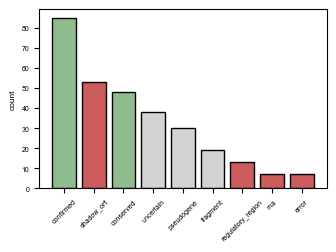

In [3]:
def figure_1(path:str='../figures/results-1.2_figure-1.pdf'):
    annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)
    annotated_results_df['error'] = annotated_results_df.category.str.contains('error')

    masks = dict()
    masks['fragment'] = annotated_results_df.category.str.contains('fragment')
    masks['pseudogene'] = annotated_results_df.category.str.contains('pseudogene')
    masks['shadow_orf'] = annotated_results_df.category.str.contains('shadow ORF')
    masks['rna'] = annotated_results_df.category.str.contains('RNA')
    masks['regulatory_region'] = annotated_results_df.category.str.contains('regulatory region')
    masks['confirmed'] = annotated_results_df.category.str.contains('confirmed')
    masks['conserved'] = annotated_results_df.category.str.contains('conserved')
    masks['uncertain'] = annotated_results_df.category.str.contains('uncertain')

    categories = list(masks.keys())
    conditions = [masks[category] for category in categories]
    annotated_results_df['category'] = np.select(conditions, categories, default='error')

    figure_df = pd.DataFrame(annotated_results_df.category.value_counts()).reset_index()

    fig, ax = get_figure()

    positions = np.arange(figure_df.category.nunique())
    heights = figure_df['count'].values 

    palette = {'confirmed':'darkseagreen', 'conserved':'darkseagreen', 'shadow_orf':'indianred', 'uncertain':'lightgray', 'pseudogene':'lightgray', 'fragment':'lightgray', 'error':'indianred', 'regulatory_region':'indianred', 'rna':'indianred'}

    ax.bar(positions, heights, color=[palette[category] for category in figure_df.category.unique()], edgecolor='black')
    ax.set_ylabel('count')
    ax.set_xticks(positions, labels=figure_df.category.unique(), rotation=45)

    save_figure(fig, path=path)

figure_1()

In [4]:
# Nearest neighbors graph (k=5) generated between all sequences in the combined dataset. 
# First reduced embedding dimensionality to 100 dimensions
graph = NeighborsGraph.load('../data/dataset/dataset_graph.pkl')

model_name = 'model_v2'

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')
results_df = pd.concat([train_results_df, test_results_df])
results_df = apply_thresholds(results_df, real_threshold=0.8, spurious_threshold=0.95)
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df = get_neighbor_info(results_df, graph)

get_neighbor_info: 100%|██████████| 276586/276586 [05:08<00:00, 896.88it/s]


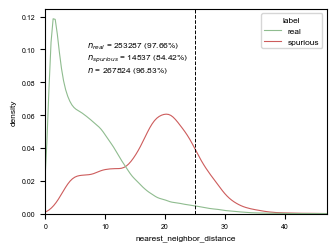

In [7]:
# Plot the distribution of neighbor distances.

def figure_2(results_df:pd.DataFrame, nearest_neighbor_distance_max:float=45, nearest_neighbor_distance_min:float=25, path:str='../figures/results-1.2_figure-2.pdf'):
    '''Distribution of the nearest-neighbor distances, used to select a reasonable nearest_neighbor_distance_min to
    define remote sequences. From the plot, it is evident that the vast majority of both real and spurious sequences have
    a neighbor whose Euclidean distance is < 30.'''
    fig, ax = get_figure()

    figure_df = results_df.copy()
    figure_df['label'] = np.where(figure_df.label == 0, 'spurious', 'real')

    palette = {'real':'darkseagreen', 'spurious':'indianred'}
    sns.kdeplot(figure_df, x='nearest_neighbor_distance', ax=ax, hue='label', palette=palette, common_norm=False)

    ax.set_xlim(xmax=nearest_neighbor_distance_max + 2)
    # print(f'figure: Num. distances beyond x-axis limit ({nearest_neighbor_distance_max}):', (figure_df.nearest_neighbor_distance > nearest_neighbor_distance_max).sum())

    ax.axvline(nearest_neighbor_distance_min, ls='--', color='black', lw=0.7)
    # ax.axvline(nearest_neighbor_distance_max, ls='--', color='black', lw=0.7)
    text = ''
    for label, df in figure_df.groupby('label'):
        # n = ((df.nearest_neighbor_distance > nearest_neighbor_distance_min) & (df.nearest_neighbor_distance < nearest_neighbor_distance_max)).sum()
        n = ((df.nearest_neighbor_distance < nearest_neighbor_distance_min)).sum()
        text += get_text(label, n, len(df))
    n = ((figure_df.nearest_neighbor_distance < nearest_neighbor_distance_min)).sum()
    text += get_text('', n, len(figure_df))
    ax.text(0.15, 0.65, text, transform=ax.transAxes)
    sns.move_legend(ax, loc='upper right')
    ax.set_ylabel('density')
    ax.set_xlim(xmin=0)

    save_figure(fig, path=path)

figure_2(results_df)

In [8]:

def count_neighbors(neighbor_ids, label:int=0, results_df:pd.DataFrame=None):
    neighbor_ids = neighbor_ids.split(',')
    try: # Not really sure why there are some cases where the neighbor ID is not in the dataset... 
        # OK, due to the fact that different duplicate IDs were dropped when I changed the dataset-building code. Only 2 cases, so not a big deal.
        return (results_df.loc[neighbor_ids].label == label).sum()
    except:
        print('count_neighbors: Missing neighbor. ')
        return None

def table_2(results_df:pd.DataFrame, nearest_neighbor_distance_min:float=30, mislabeled_ids:list=None):
    '''The results of K-nearest neighbor analysis (K=5) on remote sequences, i.e. sequences where the Euclidean distance to all nearest neighbors
    exceeds {nearest_neighbor_distance_min}. The reported values are the fraction of remote sequences where fewer than n neighbors have a matching label; 
    for example, the value in the upper right cell indicates that only 11.5% of real-labeled remote sequences have fewer than 5 real-labeled neighbors.'''

    if mislabeled_ids is not None: # Fix the mislabeled sequences if mislabeled IDs are specified.
        results_df.loc[np.intersect1d(mislabeled_ids, results_df.index), 'label'] = 0
    results_df_ = results_df.copy() # Save the original results DataFrame for the count_neighbors function.
    
    # Want to focus on the sequences which don't have a very nearby neighbor in embedding space, as it won't be productive to look at sequences with very close homologs. 
    results_df = results_df[results_df.nearest_neighbor_distance > nearest_neighbor_distance_min].copy()
    
    results_df['n_neighbors_spurious'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0, results_df=results_df_))
    results_df['n_neighbors_real'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=1, results_df=results_df_))
    results_df['n_neighbors_same_label']= [row.n_neighbors_spurious if (row.label == 0) else row.n_neighbors_real for row in results_df.itertuples()]
    results_df['length'] = results_df.seq.apply(len)
    n_total, n_real, n_spurious = len(results_df), (results_df.label == 1).sum(), (results_df.label == 0).sum()

    table_df = pd.DataFrame(index=['real', 'spurious', 'total'])
    for n in range(1, 6):
        df_ = results_df[results_df.n_neighbors_same_label < n]
        table_df[f'< {n}'] = [f'{(100 * (df_.label == 1).sum() / n_real):.2f}%', f'{(100 * (df_.label == 0).sum() / n_spurious):.2f}%', f'{100 * len(df_) / n_total:.2f}%']
    table_df['total'] = [n_real, n_spurious, n_total]
    return table_df

# Adjusting the mislabeled IDs does not affect the values in the table.
table_2(results_df) #, mislabeled_ids=mislabeled_ids)


,< 1,< 2,< 3,< 4,< 5,total
real,2.46%,4.01%,5.61%,7.11%,11.87%,1870
spurious,2.52%,4.03%,7.06%,10.92%,27.56%,595
total,2.47%,4.02%,5.96%,8.03%,15.66%,2465


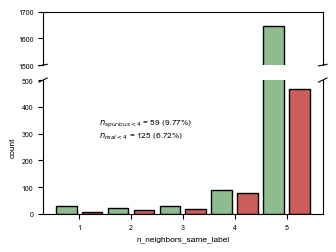

In [9]:
# Need a better way to communicate the results of Table 3. Perhaps a bar plot that shows the fraction of same-labeled nearest neighbors. 

def figure(results_df, nearest_neighbor_distance_min:float=30, mislabeled_ids:list=None):

    fig, (ax_top, ax_bottom) = get_split_figure((0, 500), (1500, 1700))

    if mislabeled_ids is not None: # Fix the mislabeled sequences if mislabeled IDs are specified.
        results_df.loc[np.intersect1d(mislabeled_ids, results_df.index), 'label'] = 0
    results_df_ = results_df.copy() # Save the original results DataFrame for the count_neighbors function.

    # Want to focus on the sequences which don't have a very nearby neighbor in embedding space, as it won't be productive to look at sequences with very close homologs. 
    results_df = results_df[results_df.nearest_neighbor_distance > nearest_neighbor_distance_min].copy()
    
    results_df['n_neighbors_spurious'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0, results_df=results_df_))
    results_df['n_neighbors_real'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=1, results_df=results_df_))
    results_df['n_neighbors_same_label']= [row.n_neighbors_spurious if (row.label == 0) else row.n_neighbors_real for row in results_df.itertuples()]
    results_df['length'] = results_df.seq.apply(len)
    n_total, n_real, n_spurious = len(results_df), (results_df.label == 1).sum(), (results_df.label == 0).sum()

    positions = np.arange(1, 6)
    offsets = {0:0.25, 1:-0.25}
    palette = {0:'indianred', 1:'darkseagreen'}

    for label, df in results_df.groupby('label'):
        heights = df.n_neighbors_same_label.value_counts().loc[positions].values 
        ax_top.bar(positions + offsets[label], heights, color=palette[label], edgecolor='black', width=0.4)
        ax_bottom.bar(positions + offsets[label], heights, color=palette[label], edgecolor='black', width=0.4)
    ax_bottom.set_xticks(positions, labels=positions)
    ax_bottom.set_xlabel('n_neighbors_same_label')
    ax_bottom.set_ylabel('count')

    n = ((results_df.label == 0) & (results_df.n_neighbors_same_label < 4)).sum()
    text = get_text('spurious < 4', n, n_spurious)
    n = ((results_df.label == 1) & (results_df.n_neighbors_same_label < 4)).sum()
    text += get_text('real < 4', n, n_real)
    ax_bottom.text(0.2, 0.5, text, transform=ax_bottom.transAxes)

    save_figure(fig, path=None)

figure(results_df, mislabeled_ids=mislabeled_ids)


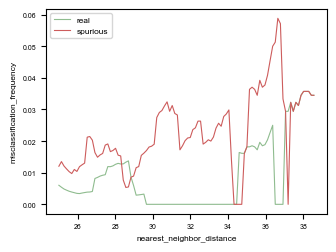

In [15]:
def figure_3(results_df, nearest_neighbor_distance_min:float=25, nearest_neighbor_distance_max:float=40, path:str='../figures/results-1.2_figure-3.pdf'):

    results_df = results_df[results_df.dataset == 'test'].copy()
    results_df = results_df[results_df.nearest_neighbor_distance > nearest_neighbor_distance_min].copy()
    results_df = results_df[results_df.nearest_neighbor_distance < nearest_neighbor_distance_max].copy()
    results_df = results_df.sort_values('nearest_neighbor_distance', ascending=False)

    delta = 1
    x_min = nearest_neighbor_distance_min
    x_max = results_df[(results_df.dataset == 'test') & (results_df.label == 0)].nearest_neighbor_distance.max()
    
    ax_df = list()
    for x in np.linspace(x_min, x_max - delta, 100):
        df = results_df[(results_df.nearest_neighbor_distance < (x + delta)) & (results_df.nearest_neighbor_distance > (x - delta))]
        row = {'nearest_neighbor_distance':x}
        row['misclassification_frequency_real'] = np.mean((df.model_label != 'real') & (df.label == 1))
        row['misclassification_frequency_spurious'] = np.mean((df.model_label != 'spurious') & (df.label == 0))
        ax_df.append(row)
    ax_df = pd.DataFrame(ax_df)
    fig, ax = get_figure()

    sns.lineplot(ax=ax, data=ax_df, y='misclassification_frequency_real', color='darkseagreen', x='nearest_neighbor_distance', label='real')
    sns.lineplot(ax=ax, data=ax_df, y='misclassification_frequency_spurious', color='indianred', x='nearest_neighbor_distance', label='spurious')
    ax.set_ylabel('misclassification_frequency')
    ax.legend()

    save_figure(fig, path=path)

    return results_df.index.values

remote_ids = figure_3(results_df)


In [ ]:
# colors = results_df.label.map({0:'indianred', 1:'darkseagreen'}).to_dict()
# graph.draw(subset_ids=remote_ids[-200:], colors=colors)

In [ ]:
# A slightly larger fraction of the spurious examples contain a token representing an unknown amino acid (“X”).
# Therefore, we also considered the possibility that the apparent robustness reflects uncertainty in the amino acid sequences. 
# However, only one of the 300 false negative sequences contains an “X “ residue, so this seems unlikely.

results_df['n_unknown'] = results_df.seq.str.count('X')

print('Maximum number of unknown amino acids in a real sequence:', results_df[results_df.label == 1].n_unknown.max())
print('Maximum number of unknown amino acids in a spurious sequence:', results_df[results_df.label == 0].n_unknown.max(), end='\n\n')

print('Percentage of real sequences with no unknown amino acids:', get_percent(((results_df.label == 1) & (results_df.n_unknown == 0)).sum(), (results_df.label == 1).sum()))
print('Percentage of spurious sequences with no unknown amino acids:', get_percent(((results_df.label == 0) & (results_df.n_unknown == 0)).sum(), (results_df.label == 0).sum()), end='\n\n')

threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)
print(f'Number of false negatives with an unknown amino acid:', ((results_df.model_label == 0) & (results_df.label == 1) & (results_df.n_unknown > 0)).sum())

Maximum number of unknown amino acids in a real sequence: 19
Maximum number of unknown amino acids in a spurious sequence: 235

Percentage of real sequences with no unknown amino acids: 99.83%
Percentage of spurious sequences with no unknown amino acids: 98.85%

Number of false negatives with an unknown amino acid: 0


In [ ]:
# def figure_3(results_df, nearest_neighbor_distance_min:float=25, max_distance_to_nearest_neighbor:float=45, threshold:float=0.95, path:str='../figures/results-1.2_figure-3.pdf'):

#     # results_df = results_df[results_df.dataset == 'test'].copy()
#     results_df = results_df[results_df.distance_to_nearest_neighbor > nearest_neighbor_distance_min].copy()
#     results_df = results_df[results_df.distance_to_nearest_neighbor < max_distance_to_nearest_neighbor].copy()
#     bin_labels, bins = pd.cut(results_df.distance_to_nearest_neighbor, np.arange(nearest_neighbor_distance_min, max_distance_to_nearest_neighbor + 1), retbins=True, labels=False)
#     # print(bins)
#     x_min = nearest_neighbor_distance_min
#     x_max = results_df[(results_df.dataset == 'test') & (results_df.label == 0)].distance_to_nearest_neighbor.max()
    
#     ax_df = pd.DataFrame(index=results_df.index)
#     ax_df['dataset'] = results_df.dataset
#     ax_df['bin_label'] = bin_labels
#     ax_df['distance_to_nearest_neighbor'] = results_df.distance_to_nearest_neighbor
#     ax_df['bin_value'] = ax_df.bin_label.map(ax_df.groupby('bin_label').distance_to_nearest_neighbor.mean())
#     ax_df['model_label'] = np.where(results_df.model_output_0 > threshold, 'spurious', 'real')
#     ax_df['label'] = ['real' if (label == 1) else 'spurious' for label in results_df.label]
#     ax_df['correct'] = ax_df.label == ax_df.model_label
#     ax_df['incorrect'] = ax_df.label != ax_df.model_label
#     ax_df['is_spurious'] = ax_df.label == 'spurious'
#     ax_df['is_real'] = ax_df.label == 'real'

#     fig, ax = get_figure()
#     ax_ = ax.twinx()

#     palette = {'spurious':'indianred', 'real':'darkseagreen'}

#     offset = 0
#     # sns.lineplot(ax=ax_a, data=ax_df[ax_df.dataset == 'test'], x='bin_label', y='correct', hue='label', palette=palette, errorbar=None)
#     for label, df in ax_df[ax_df.dataset == 'test'].groupby('label'):
#         x = df.groupby('bin_label').bin_value.first()
#         y = df.groupby('bin_label').incorrect.sum()
#         sns.scatterplot(ax=ax, x=x.values.ravel() + offset, y=y.values.ravel(), color=palette[label], label=label)
#         offset += 0.1

#     for label, df in ax_df[ax_df.dataset == 'test'].groupby('label'):
#         x = df.groupby('bin_label').bin_value.first().values.ravel()
#         y = [(df.distance_to_nearest_neighbor > x_).sum() for x_ in x]
#         sns.lineplot(ax=ax_, x=x, y=y, color=palette[label], ls=':')

#     ax.set_yticks([0, 1, 2, 3, 4, 5])
#     ax.set_ylim(ymin=0.5)
#     ax.set_xlim(xmax=x_max, xmin=x_min)
#     ax.set_ylabel('num. misclassified')
#     ax_.set_ylabel('count')
#     ax_.set_yscale('log')
#     ax.set_xlabel('distance to nearest neighbor')
    
#     save_figure(fig, path=path)

# figure_2(results_df)

